In [1]:
import pennylane as qml
from pennylane import numpy as np
import scipy
import matplotlib.pyplot as plt
from globalVars import *
from model_3qubit import *

from GRADest_3Q import EstGrad
from EQFIMest_3Q import Est_EQFIM

## Quantum Neural Network

(<Figure size 1300x400 with 1 Axes>, <Axes: >)

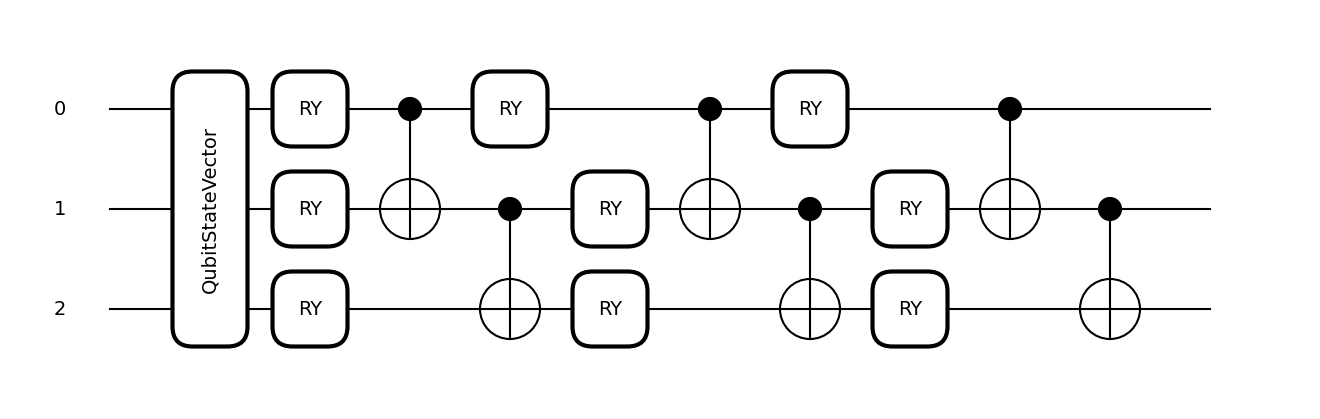

In [2]:
random_state = np.random.rand(dim)
random_state = random_state /np.linalg.norm(random_state)
qml.draw_mpl(QNN)(np.zeros(nparams),random_state)

### Model Initialization 

In [3]:
S_pItr = 6  # no. of samples used per-iteration 

nStep = 350
nItr = 100
step_size = 0.0025

Bsize = S_pItr*nItr

In [4]:
phiTrain = np.load('3-qubitsPhiTrain_v1.npy')
labelTrain = np.load('3-qubitsLabelTrain_v1.npy')

phiTrain.requires_grad = False
labelTrain.requires_grad = False

In [5]:
'QNSCD Dataset'
phiTrainNCGD = phiTrain
labelTrainNCGD = labelTrain

'SGD Dataset'
phiTrainSGD = phiTrain
labelTrainSGD = labelTrain

In [6]:
### Optimal Expected Loss
Opt_cost = []
itrBatch = np.linspace(0,Bsize*nStep,nStep,endpoint = False,dtype = 'int').tolist()
for itr1 in itrBatch:
    expOperator = 0
    for itr2 in range(Bsize):
        temp_phi = phiTrain[:,itr1+itr2]
        op = np.matmul(temp_phi.reshape(dim,1),temp_phi.reshape(1,dim))
        expOperator = expOperator + labelTrain[itr1+itr2]*op
    expOperator = expOperator/Bsize
    opt_value = 0.5*(1-sum(abs(np.linalg.svd(expOperator)[1])))
    Opt_cost.append(opt_value)

file_name = "3Q-Minimum Expected Loss"
np.save(file_name,Opt_cost)

In [7]:
SGD2_cost = np.load("3Q 2-RQSGD_6s Expected Loss.npy")
SGD2_Ecost = np.load("3Q 2-RQSGD_6s Empirical Loss.npy")

SGD6_cost = np.load("3Q 6-RQSGD Expected Loss.npy")
SGD6_Ecost = np.load("3Q 6-RQSGD Empirical Loss.npy")

# Optimizers

In [8]:
'QNN outputs yhat'
dev = qml.device("default.qubit", wires=nqubits, shots=1)

@qml.qnode(dev,interface='autograd')
def circuit_test(params,state):
    QNN(params,state)
    return qml.sample(qml.Hermitian(M,wires=list(range(nqubits))))

In [9]:
init_params = np.random.uniform(low=0, high=2*np.pi, size=nparams, requires_grad=True)
init_params = np.array([1.32856251, 6.08211092, 4.11432613, 0.07024644, 0.52676639, 3.77414277,
 1.01944363, 4.58404229, 3.39006004], requires_grad=True)
'cost initialization'
phiTrain0 = phiTrain[:,-1*(Bsize+1):-1]
labelTrain0 = labelTrain[-1*(Bsize+1):-1]
temp_cost = sum([ps_expLoss(init_params,phiTrain0[:,itr],labelTrain0[itr]) for itr in range(Bsize)])/Bsize
print("Initial Average Per-Sample Expected Loss: ",temp_cost)

count = 0
for itr in range(Bsize):
    if circuit_test(init_params,phiTrain0[:,itr]) != labelTrain0[itr]:
        count += 1
temp_Ecost = count/Bsize
print("Initial Average Empirical Loss", temp_Ecost)

Initial Average Per-Sample Expected Loss:  0.5609244056946506
Initial Average Empirical Loss 0.5733333333333334


## Quantum Natural Stochastic Pairwise Coordinate Descent (2-QNSCD)

### 2-QNSCD with $\beta$ = 0.70

In [10]:
Beta = 0.70

NCGDparams = np.array(init_params)
NCGD_cost = []
NCGD_Ecost = []

NCGD_cost.append(temp_cost)
NCGD_Ecost.append(temp_Ecost)

itrSample = np.linspace(0,Bsize,nItr,endpoint = False,dtype = 'int').tolist()
for itr1 in range(nStep):
    phiT = phiTrainNCGD[:,Bsize*itr1:Bsize*(itr1+1)]
    labelT = labelTrainNCGD[Bsize*itr1:Bsize*(itr1+1)]
    
    for itr2 in range(nItr):
        itr3 = itrSample[itr2]
        
        ### Randomly selecting a pair of coordinate
        idx = sorted(np.random.permutation(nparams)[0:2].tolist())

        ### Gradient estimation
        y1, b1 = EstGrad(NCGDparams,phiT[:,itr3],idx[0])
        y2, b2 = EstGrad(NCGDparams,phiT[:,itr3+1],idx[1])
        b1 = (1-b1)/2
        b2 = (1-b2)/2

        grad = [-1*((-1)**b1)*loss(y1,labelT[itr3]),-1*((-1)**b2)*loss(y2,labelT[itr3+1])]
        
        ### E-QFIM estimation
        metric = Est_EQFIM(NCGDparams,idx,phiT[:,itr3+2:itr3+S_pItr],Beta)

        ### double-parameters update
        NCGDparams[idx] = NCGDparams[idx] - (step_size)*np.dot(np.linalg.inv(metric),grad) 
        
    ### average per-sample expectd loss calculation
    energy = sum([ps_expLoss(NCGDparams,phiT[:,itr],labelT[itr]) for itr in range(Bsize)])/Bsize
    NCGD_cost.append(energy)
    
    ### average empirical loss calculation
    NCGDcount = 0
    for itr in range(Bsize):
        if circuit_test(NCGDparams,phiT[:,itr]) != labelT[itr]:
            NCGDcount += 1
    NCGD_Ecost.append(NCGDcount/Bsize)
    
    print("Batch count: {:2d}, Avg. per-sample expected Loss: {:.5f}".format(itr1,energy))

file_name1 = "3Q Expected Loss " + str(Beta)
file_name2 = "3Q Empirical Loss" + str(Beta)

np.save(file_name1,NCGD_cost)
np.save(file_name2,NCGD_Ecost)

Batch count:  0, Avg. per-sample expected Loss: 0.56092
Batch count:  1, Avg. per-sample expected Loss: 0.56623
Batch count:  2, Avg. per-sample expected Loss: 0.55452
Batch count:  3, Avg. per-sample expected Loss: 0.56686
Batch count:  4, Avg. per-sample expected Loss: 0.55213
Batch count:  5, Avg. per-sample expected Loss: 0.55527
Batch count:  6, Avg. per-sample expected Loss: 0.55623
Batch count:  7, Avg. per-sample expected Loss: 0.54534
Batch count:  8, Avg. per-sample expected Loss: 0.54622
Batch count:  9, Avg. per-sample expected Loss: 0.55462
Batch count: 10, Avg. per-sample expected Loss: 0.55503
Batch count: 11, Avg. per-sample expected Loss: 0.55989
Batch count: 12, Avg. per-sample expected Loss: 0.54747
Batch count: 13, Avg. per-sample expected Loss: 0.53949
Batch count: 14, Avg. per-sample expected Loss: 0.55524
Batch count: 15, Avg. per-sample expected Loss: 0.55659
Batch count: 16, Avg. per-sample expected Loss: 0.55484
Batch count: 17, Avg. per-sample expected Loss: 

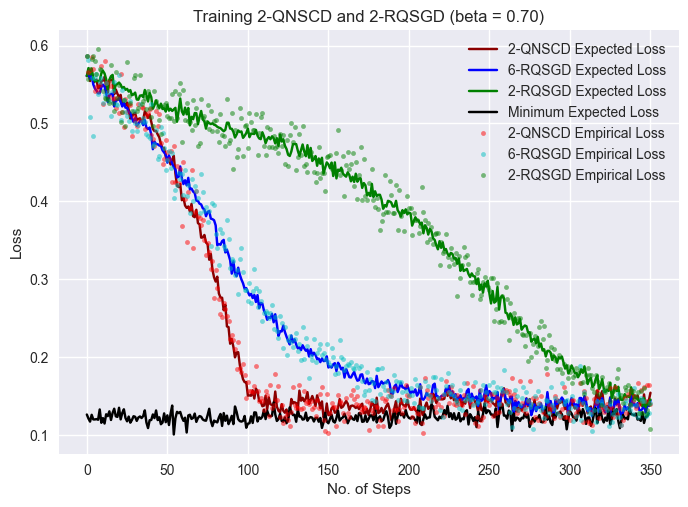

In [11]:
plt.style.use("seaborn-v0_8")
plt.plot(NCGD_cost, "darkred", label="2-QNSCD Expected Loss")
plt.plot(SGD6_cost, "b", label="6-RQSGD Expected Loss")
plt.plot(SGD2_cost, "g", label="2-RQSGD Expected Loss")

plt.plot(Opt_cost, "k", label="Minimum Expected Loss")
plt.plot(NCGD_Ecost, "r.",alpha=0.5, label="2-QNSCD Empirical Loss")
plt.plot(SGD6_Ecost, "c.",alpha=0.5, label="6-RQSGD Empirical Loss")
plt.plot(SGD2_Ecost, "g.",alpha=0.5, label="2-RQSGD Empirical Loss")


plt.title("Training 2-QNSCD and 2-RQSGD (beta = 0.70)")
plt.ylabel("Loss")
plt.xlabel("No. of Steps")
plt.legend()

### 2-QNSCD with $\beta$ = 0.8

In [12]:
Beta = 0.8

NCGDparams = np.array(init_params)
NCGD_cost = []
NCGD_Ecost = []

NCGD_cost.append(temp_cost)
NCGD_Ecost.append(temp_Ecost)

itrSample = np.linspace(0,Bsize,nItr,endpoint = False,dtype = 'int').tolist()
for itr1 in range(nStep):
    phiT = phiTrainNCGD[:,Bsize*itr1:Bsize*(itr1+1)]
    labelT = labelTrainNCGD[Bsize*itr1:Bsize*(itr1+1)]
    
    for itr2 in range(nItr):
        itr3 = itrSample[itr2]
        
        ### Randomly selecting a pair of coordinate
        idx = sorted(np.random.permutation(nparams)[0:2].tolist())

        ### Gradient estimation
        y1, b1 = EstGrad(NCGDparams,phiT[:,itr3],idx[0])
        y2, b2 = EstGrad(NCGDparams,phiT[:,itr3+1],idx[1])
        b1 = (1-b1)/2
        b2 = (1-b2)/2

        grad = [-1*((-1)**b1)*loss(y1,labelT[itr3]),-1*((-1)**b2)*loss(y2,labelT[itr3+1])]
        
        ### E-QFIM estimation
        metric = Est_EQFIM(NCGDparams,idx,phiT[:,itr3+2:itr3+S_pItr],Beta)

        ### double-parameters update
        NCGDparams[idx] = NCGDparams[idx] - (step_size)*np.dot(np.linalg.inv(metric),grad) 
        
    ### average per-sample expectd loss calculation
    energy = sum([ps_expLoss(NCGDparams,phiT[:,itr],labelT[itr]) for itr in range(Bsize)])/Bsize
    NCGD_cost.append(energy)
    
    ### average empirical loss calculation
    NCGDcount = 0
    for itr in range(Bsize):
        if circuit_test(NCGDparams,phiT[:,itr]) != labelT[itr]:
            NCGDcount += 1
    NCGD_Ecost.append(NCGDcount/Bsize)
    
    print("Batch count: {:2d}, Avg. per-sample expected Loss: {:.5f}".format(itr1,energy))

file_name1 = "3Q Expected Loss " + str(Beta)
file_name2 = "3Q Empirical Loss" + str(Beta)

np.save(file_name1,NCGD_cost)
np.save(file_name2,NCGD_Ecost)

Batch count:  0, Avg. per-sample expected Loss: 0.56092
Batch count:  1, Avg. per-sample expected Loss: 0.56837
Batch count:  2, Avg. per-sample expected Loss: 0.55724
Batch count:  3, Avg. per-sample expected Loss: 0.56359
Batch count:  4, Avg. per-sample expected Loss: 0.55150
Batch count:  5, Avg. per-sample expected Loss: 0.54721
Batch count:  6, Avg. per-sample expected Loss: 0.54642
Batch count:  7, Avg. per-sample expected Loss: 0.54705
Batch count:  8, Avg. per-sample expected Loss: 0.54491
Batch count:  9, Avg. per-sample expected Loss: 0.55460
Batch count: 10, Avg. per-sample expected Loss: 0.55774
Batch count: 11, Avg. per-sample expected Loss: 0.55508
Batch count: 12, Avg. per-sample expected Loss: 0.54634
Batch count: 13, Avg. per-sample expected Loss: 0.53074
Batch count: 14, Avg. per-sample expected Loss: 0.54763
Batch count: 15, Avg. per-sample expected Loss: 0.55088
Batch count: 16, Avg. per-sample expected Loss: 0.54880
Batch count: 17, Avg. per-sample expected Loss: 

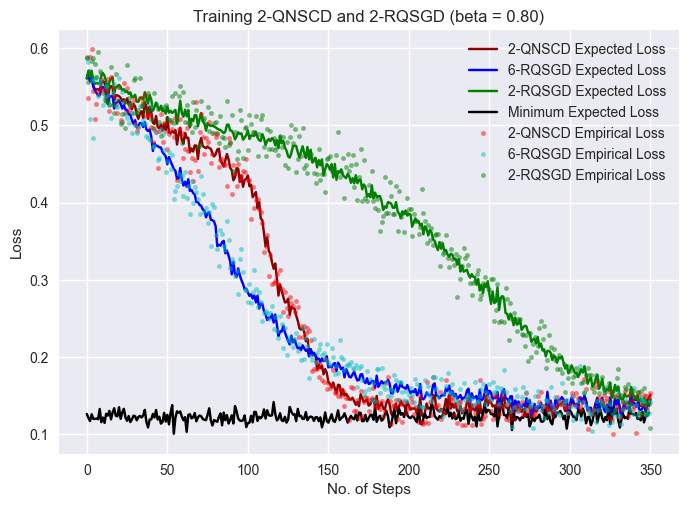

In [13]:
plt.style.use("seaborn-v0_8")
plt.plot(NCGD_cost, "darkred", label="2-QNSCD Expected Loss")
plt.plot(SGD6_cost, "b", label="6-RQSGD Expected Loss")
plt.plot(SGD2_cost, "g", label="2-RQSGD Expected Loss")

plt.plot(Opt_cost, "k", label="Minimum Expected Loss")
plt.plot(NCGD_Ecost, "r.",alpha=0.5, label="2-QNSCD Empirical Loss")
plt.plot(SGD6_Ecost, "c.",alpha=0.5, label="6-RQSGD Empirical Loss")
plt.plot(SGD2_Ecost, "g.",alpha=0.5, label="2-RQSGD Empirical Loss")


plt.title("Training 2-QNSCD and 2-RQSGD (beta = 0.80)")
plt.ylabel("Loss")
plt.xlabel("No. of Steps")
plt.legend()

### 2-QNSCD with $\beta$ = 0.9

In [15]:
Beta = 0.9

NCGDparams = np.array(init_params)
NCGD_cost = []
NCGD_Ecost = []

NCGD_cost.append(temp_cost)
NCGD_Ecost.append(temp_Ecost)

itrSample = np.linspace(0,Bsize,nItr,endpoint = False,dtype = 'int').tolist()
for itr1 in range(nStep):
    phiT = phiTrainNCGD[:,Bsize*itr1:Bsize*(itr1+1)]
    labelT = labelTrainNCGD[Bsize*itr1:Bsize*(itr1+1)]
    
    for itr2 in range(nItr):
        itr3 = itrSample[itr2]
        
        ### Randomly selecting a pair of coordinate
        idx = sorted(np.random.permutation(nparams)[0:2].tolist())

        ### Gradient estimation
        y1, b1 = EstGrad(NCGDparams,phiT[:,itr3],idx[0])
        y2, b2 = EstGrad(NCGDparams,phiT[:,itr3+1],idx[1])
        b1 = (1-b1)/2
        b2 = (1-b2)/2

        grad = [-1*((-1)**b1)*loss(y1,labelT[itr3]),-1*((-1)**b2)*loss(y2,labelT[itr3+1])]
        
        ### E-QFIM estimation
        metric = Est_EQFIM(NCGDparams,idx,phiT[:,itr3+2:itr3+S_pItr],Beta)

        ### double-parameters update
        NCGDparams[idx] = NCGDparams[idx] - (step_size)*np.dot(np.linalg.inv(metric),grad) 
        
    ### average per-sample expectd loss calculation
    energy = sum([ps_expLoss(NCGDparams,phiT[:,itr],labelT[itr]) for itr in range(Bsize)])/Bsize
    NCGD_cost.append(energy)
    
    ### average empirical loss calculation
    NCGDcount = 0
    for itr in range(Bsize):
        if circuit_test(NCGDparams,phiT[:,itr]) != labelT[itr]:
            NCGDcount += 1
    NCGD_Ecost.append(NCGDcount/Bsize)
    
    print("Batch count: {:2d}, Avg. per-sample expected Loss: {:.5f}".format(itr1,energy))

file_name1 = "3Q Expected Loss " + str(Beta)
file_name2 = "3Q Empirical Loss" + str(Beta)

np.save(file_name1,NCGD_cost)
np.save(file_name2,NCGD_Ecost)

Batch count:  0, Avg. per-sample expected Loss: 0.56092
Batch count:  1, Avg. per-sample expected Loss: 0.57063
Batch count:  2, Avg. per-sample expected Loss: 0.56135
Batch count:  3, Avg. per-sample expected Loss: 0.56813
Batch count:  4, Avg. per-sample expected Loss: 0.55459
Batch count:  5, Avg. per-sample expected Loss: 0.55159
Batch count:  6, Avg. per-sample expected Loss: 0.55009
Batch count:  7, Avg. per-sample expected Loss: 0.55045
Batch count:  8, Avg. per-sample expected Loss: 0.55091
Batch count:  9, Avg. per-sample expected Loss: 0.55387
Batch count: 10, Avg. per-sample expected Loss: 0.55864
Batch count: 11, Avg. per-sample expected Loss: 0.54909
Batch count: 12, Avg. per-sample expected Loss: 0.54292
Batch count: 13, Avg. per-sample expected Loss: 0.53238
Batch count: 14, Avg. per-sample expected Loss: 0.54271
Batch count: 15, Avg. per-sample expected Loss: 0.54254
Batch count: 16, Avg. per-sample expected Loss: 0.54770
Batch count: 17, Avg. per-sample expected Loss: 

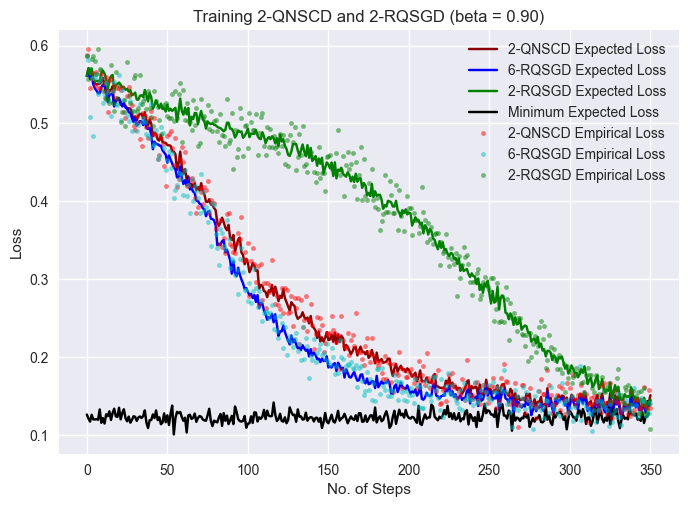

In [16]:
plt.style.use("seaborn-v0_8")
plt.plot(NCGD_cost, "darkred", label="2-QNSCD Expected Loss")
plt.plot(SGD6_cost, "b", label="6-RQSGD Expected Loss")
plt.plot(SGD2_cost, "g", label="2-RQSGD Expected Loss")

plt.plot(Opt_cost, "k", label="Minimum Expected Loss")
plt.plot(NCGD_Ecost, "r.",alpha=0.5, label="2-QNSCD Empirical Loss")
plt.plot(SGD6_Ecost, "c.",alpha=0.5, label="6-RQSGD Empirical Loss")
plt.plot(SGD2_Ecost, "g.",alpha=0.5, label="2-RQSGD Empirical Loss")


plt.title("Training 2-QNSCD and 2-RQSGD (beta = 0.90)")
plt.ylabel("Loss")
plt.xlabel("No. of Steps")
plt.legend()

### 2-QNSCD with $\beta$ = 1

In [17]:
Beta = 1.0

NCGDparams = np.array(init_params)
NCGD_cost = []
NCGD_Ecost = []

NCGD_cost.append(temp_cost)
NCGD_Ecost.append(temp_Ecost)

itrSample = np.linspace(0,Bsize,nItr,endpoint = False,dtype = 'int').tolist()
for itr1 in range(nStep):
    phiT = phiTrainNCGD[:,Bsize*itr1:Bsize*(itr1+1)]
    labelT = labelTrainNCGD[Bsize*itr1:Bsize*(itr1+1)]
    
    for itr2 in range(nItr):
        itr3 = itrSample[itr2]
        
        ### Randomly selecting a pair of coordinate
        idx = sorted(np.random.permutation(nparams)[0:2].tolist())

        ### Gradient estimation
        y1, b1 = EstGrad(NCGDparams,phiT[:,itr3],idx[0])
        y2, b2 = EstGrad(NCGDparams,phiT[:,itr3+1],idx[1])
        b1 = (1-b1)/2
        b2 = (1-b2)/2

        grad = [-1*((-1)**b1)*loss(y1,labelT[itr3]),-1*((-1)**b2)*loss(y2,labelT[itr3+1])]
        
        ### E-QFIM estimation
        metric = Est_EQFIM(NCGDparams,idx,phiT[:,itr3+2:itr3+S_pItr],Beta)

        ### double-parameters update
        NCGDparams[idx] = NCGDparams[idx] - (step_size)*np.dot(np.linalg.inv(metric),grad) 
        
    ### average per-sample expectd loss calculation
    energy = sum([ps_expLoss(NCGDparams,phiT[:,itr],labelT[itr]) for itr in range(Bsize)])/Bsize
    NCGD_cost.append(energy)
    
    ### average empirical loss calculation
    NCGDcount = 0
    for itr in range(Bsize):
        if circuit_test(NCGDparams,phiT[:,itr]) != labelT[itr]:
            NCGDcount += 1
    NCGD_Ecost.append(NCGDcount/Bsize)
    
    print("Batch count: {:2d}, Avg. per-sample expected Loss: {:.5f}".format(itr1,energy))

file_name1 = "3Q Expected Loss " + str(Beta)
file_name2 = "3Q Empirical Loss" + str(Beta)

np.save(file_name1,NCGD_cost)
np.save(file_name2,NCGD_Ecost)

Batch count:  0, Avg. per-sample expected Loss: 0.56092
Batch count:  1, Avg. per-sample expected Loss: 0.56791
Batch count:  2, Avg. per-sample expected Loss: 0.55784
Batch count:  3, Avg. per-sample expected Loss: 0.56555
Batch count:  4, Avg. per-sample expected Loss: 0.55235
Batch count:  5, Avg. per-sample expected Loss: 0.54791
Batch count:  6, Avg. per-sample expected Loss: 0.55003
Batch count:  7, Avg. per-sample expected Loss: 0.54715
Batch count:  8, Avg. per-sample expected Loss: 0.54990
Batch count:  9, Avg. per-sample expected Loss: 0.55978
Batch count: 10, Avg. per-sample expected Loss: 0.56081
Batch count: 11, Avg. per-sample expected Loss: 0.55468
Batch count: 12, Avg. per-sample expected Loss: 0.55099
Batch count: 13, Avg. per-sample expected Loss: 0.53538
Batch count: 14, Avg. per-sample expected Loss: 0.54852
Batch count: 15, Avg. per-sample expected Loss: 0.55259
Batch count: 16, Avg. per-sample expected Loss: 0.55963
Batch count: 17, Avg. per-sample expected Loss: 

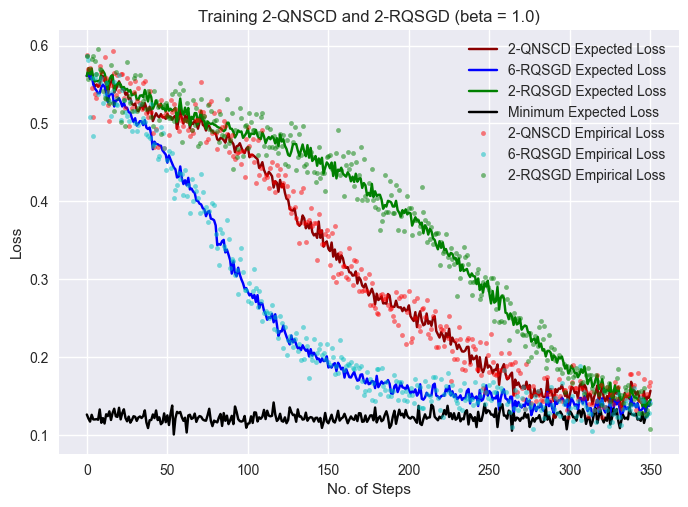

In [18]:
plt.style.use("seaborn-v0_8")
plt.plot(NCGD_cost, "darkred", label="2-QNSCD Expected Loss")
plt.plot(SGD6_cost, "b", label="6-RQSGD Expected Loss")
plt.plot(SGD2_cost, "g", label="2-RQSGD Expected Loss")

plt.plot(Opt_cost, "k", label="Minimum Expected Loss")
plt.plot(NCGD_Ecost, "r.",alpha=0.5, label="2-QNSCD Empirical Loss")
plt.plot(SGD6_Ecost, "c.",alpha=0.5, label="6-RQSGD Empirical Loss")
plt.plot(SGD2_Ecost, "g.",alpha=0.5, label="2-RQSGD Empirical Loss")


plt.title("Training 2-QNSCD and 2-RQSGD (beta = 1.0)")
plt.ylabel("Loss")
plt.xlabel("No. of Steps")
plt.legend()